In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import h5py
import transit
import numpy as np
import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator

## Data

First, we'll download the light curve and PCA basis file:

In [70]:
!mkdir -p demo
!wget -P demo http://bbq.dfm.io/ketu/elcs/c1.h5
!wget -P demo http://bbq.dfm.io/ketu/lightcurves/c1/201600000/13000/ktwo201613023-c01_lpd-lc.fits
!wget -P demo http://bbq.dfm.io/ketu/target_pixel_files/c1/201600000/13000/ktwo201613023-c01_lpd-targ.fits.gz

--2015-02-14 18:42:29--  http://bbq.dfm.io/ketu/target_pixel_files/c1/201600000/13000/ktwo201613023-c01_lpd-targ.fits.gz
Resolving bbq.dfm.io... 128.122.53.52
Connecting to bbq.dfm.io|128.122.53.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10181290 (9.7M) [application/octet-stream]
Saving to: 'demo/ktwo201613023-c01_lpd-targ.fits.gz'

100%[======================================>] 10,181,290  1.62MB/s   in 5.9s   

2015-02-14 18:42:35 (1.64 MB/s) - 'demo/ktwo201613023-c01_lpd-targ.fits.gz' saved [10181290/10181290]



Now we'll use `ketu` to load this:

In [17]:
pipe = ketu.k2.Data(basepath="./demo/cache")
pipe = ketu.k2.Likelihood(pipe)

In [18]:
blah = dict(zip(
    "epicid,ln_R_star,ln_R_star_minus,ln_R_star_plus,ln_M_star,ln_M_star_minus,ln_M_star_plus,q1,q1_minus,q1_plus,q2,q2_minus,q2_plus,ln_R_p,ln_R_p_minus,ln_R_p_plus,ln_P,ln_P_minus,ln_P_plus,t0,t0_minus,t0_plus,b,b_minus,b_plus,sqrt_e_sin_omega,sqrt_e_sin_omega_minus,sqrt_e_sin_omega_plus,sqrt_e_cos_omega,sqrt_e_cos_omega_minus,sqrt_e_cos_omega_plus,comp_period,comp_period_minus,comp_period_plus,comp_ln_ror,comp_ln_ror_minus,comp_ln_ror_plus,comp_ror,comp_ror_minus,comp_ror_plus,comp_e,comp_e_minus,comp_e_plus,comp_omega,comp_omega_minus,comp_omega_plus".split(","),
    [201555883,-0.20835181440770786,0.9034065813507004,0.7415585783019885,0.38902955155232966,1.0919357306710915,1.297302740592697,0.3898006128398148,0.24468764003017057,0.44448179640270236,0.4113656919581559,0.2584746498856678,0.40253807994642216,-3.0057556079075964,0.9371160335643216,0.8047301359459467,1.7572695800570053,4.041898626283569e-05,3.52852204827947e-05,5.3172617467182715,0.004966184141713015,0.002680301719139244,0.578982774044725,0.33614925460238493,0.26608897184973246,-0.310485527182936,0.4813974475737193,0.5073772502915499,0.0092402276208095,0.4368314251043936,0.3554076477412138,5.796588646138957,0.00023428750199627757,0.0002045375169821284,-2.806093936157078,0.05462129371404245,0.10732557117574393,0.0604406168187637,0.0032128022367867784,0.006847719577711978,0.34689977517390524,0.22804493159762193,0.3973681289881602,-1.332102339184712,0.9055950739152976,2.126657865998414]
))

In [27]:
period, t0, depth = blah["comp_period"], blah["t0"], blah["comp_ror"] ** 2 * 1e3

In [125]:
201555883 
query = dict(
    light_curve_file="/export/bbq2/dfm/k2/web/lightcurves/c1/201500000/55000/ktwo201555883-c01_lpd-lc.fits",
    initial_time=1975.,
    basis_file="/export/bbq2/dfm/k2/web/elcs/c1.h5",
    nbasis=40,
)

In [126]:
r = pipe.query(**query)

Using cached value in Likelihood


In [127]:
lc = r.model_light_curves[0]

In [128]:
mu = lc.predict()

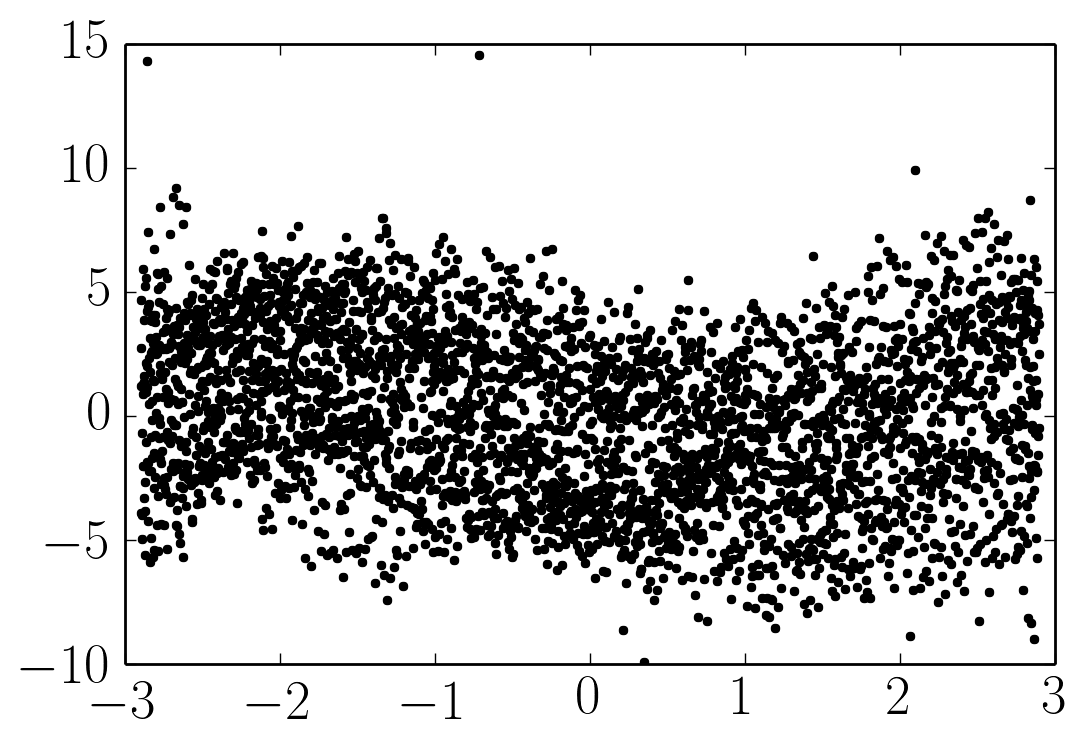

In [129]:
t = (lc.time - t0 + 0.5 * period) % period - 0.5 * period
pl.plot(t, lc.flux - mu, ".k");

In [130]:
r = lc.flux - mu
w = 20
bg = np.ones_like(r)
for i in range(w, len(r)-w):
    bg[i] = np.median(r[i-w:i+w+1])

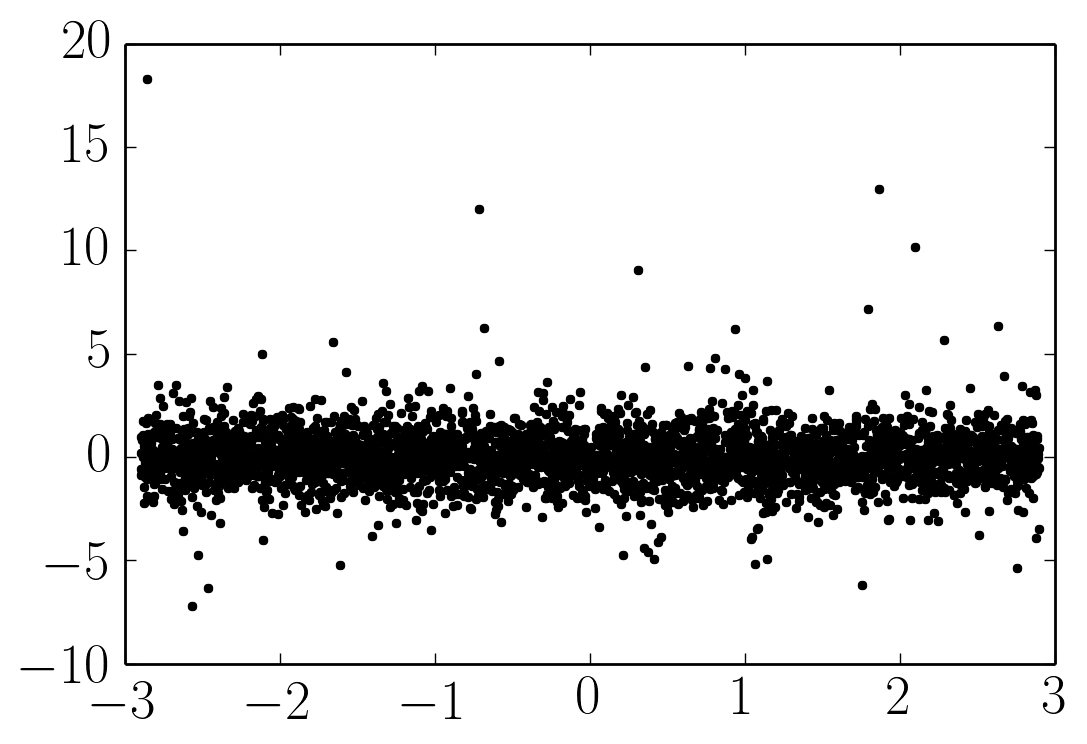

In [132]:
pl.plot(t[w:-w], r[w:-w]-bg[w:-w], ".k")

In [58]:
from scipy.linalg import cho_solve
w0 = cho_solve(lc._factor, np.dot(lc.basis, lc.flux))

model = np.zeros_like(lc.flux)
m = np.abs((lc.time - t0 + 0.5 * period) % period - 0.5 * period) < 0.2
model[m] = -depth

w1 = cho_solve(lc._factor, np.dot(lc.basis, model))

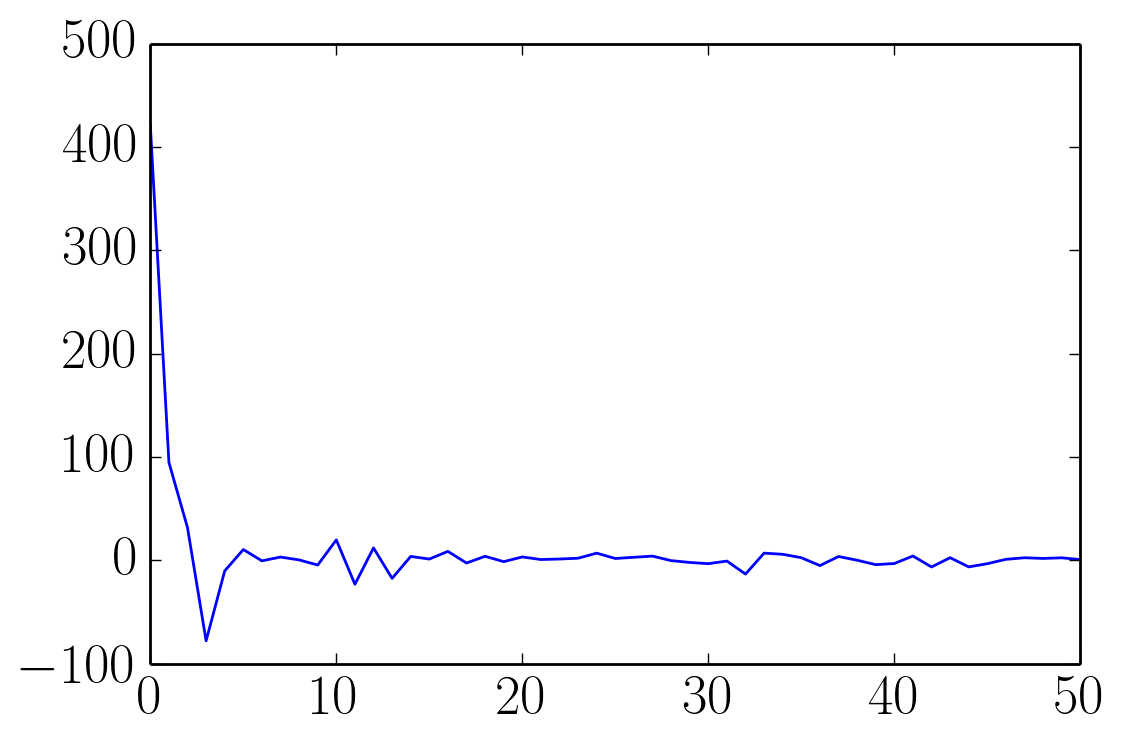

In [61]:
pl.plot(w1)

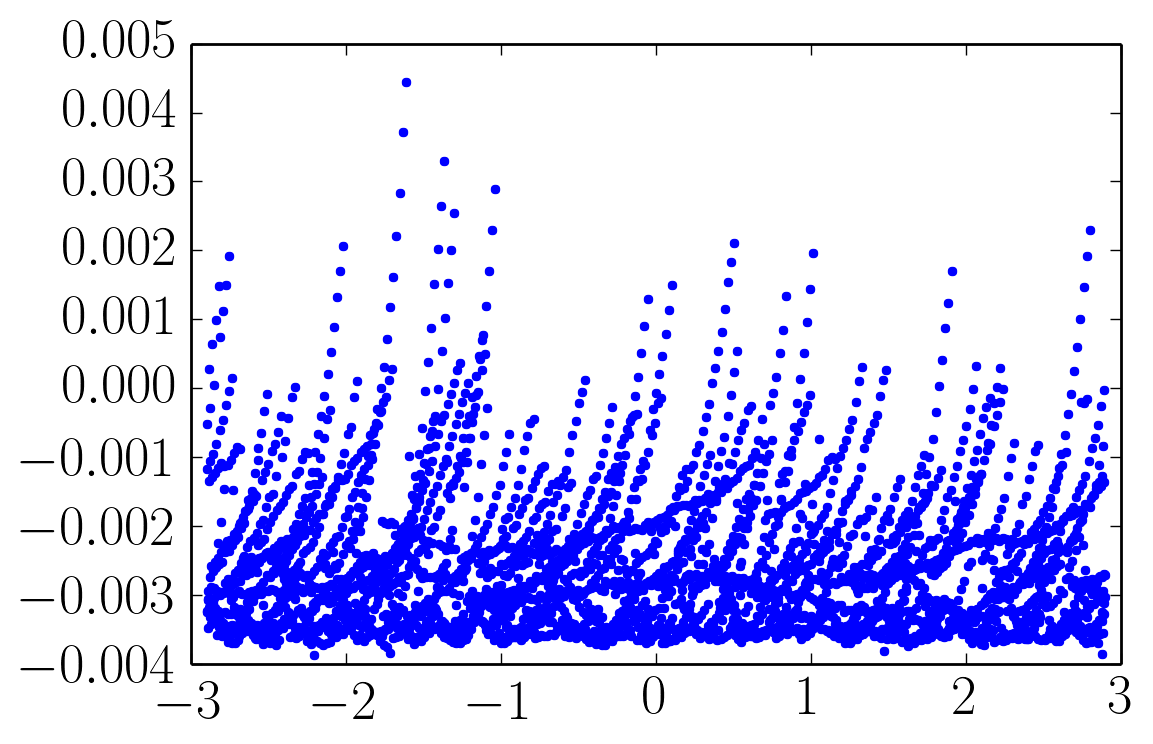

In [64]:
pl.plot(t, lc.basis[np.argmax(np.abs(w1))], ".")

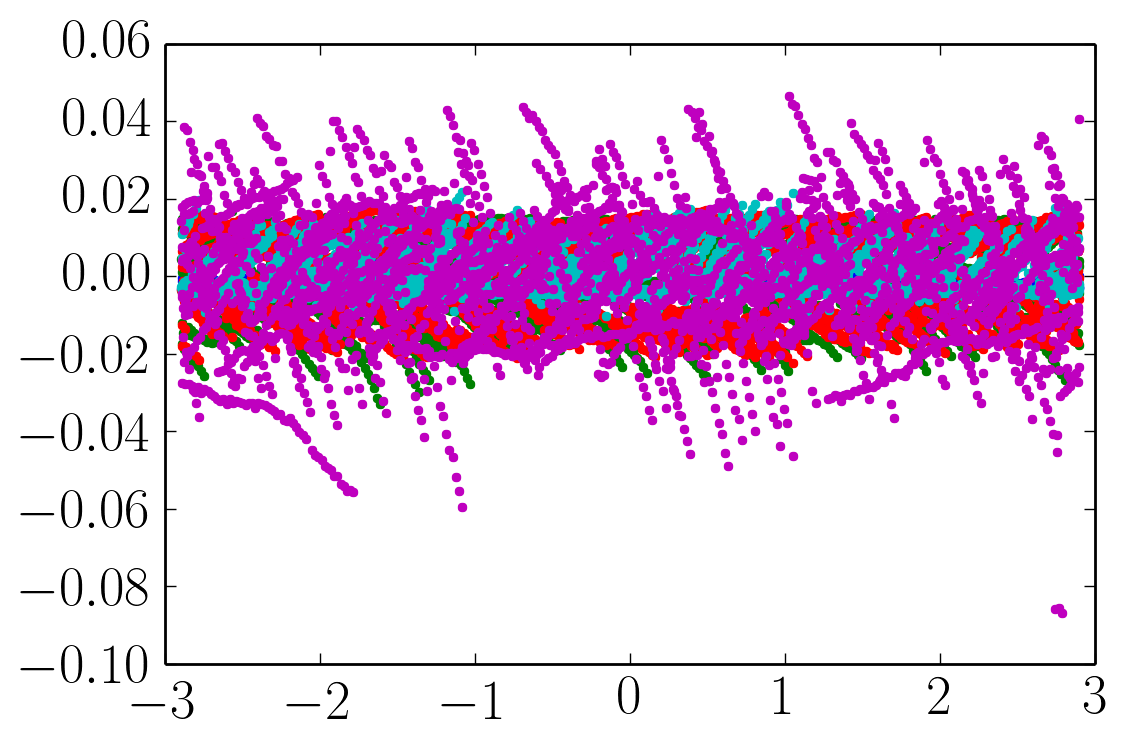

In [57]:
t = (lc.time - t0 + 0.5 * period) % period - 0.5 * period
[pl.plot(t, lc.basis[i], ".") for i in range(5)];
# pl.plot(t, lc.flux - lc.predict(lc.flux - model), ".r");

In [3]:
import ketu

pipe = ketu.k2.Data(basepath="./demo/cache")
pipe = ketu.k2.Likelihood(pipe)
pipe = ketu.k2.FP(pipe)

/home/dfm/anaconda/lib/python2.7/site-packages/astropy/config/configuration.py:682: ConfigurationMissingWarning: Configuration defaults will be used due to OSError:Could not find unix home directory to search for astropy config dir on None
  warn(ConfigurationMissingWarning(msg))


In [99]:
query = dict(
    light_curve_file="demo/ktwo201613023-c01_lpd-lc.fits",
    target_pixel_file="demo/ktwo201613023-c01_lpd-targ.fits.gz",
    initial_time=1975.,
    basis_file="demo/c1.h5",
    nbasis=150,
)

In [100]:
result = pipe.query(**query)

Using cached value in FP


In [101]:
lc = result.model_light_curves[0]

Using cached value in Likelihood


In [106]:
fp_model = result.fp_model

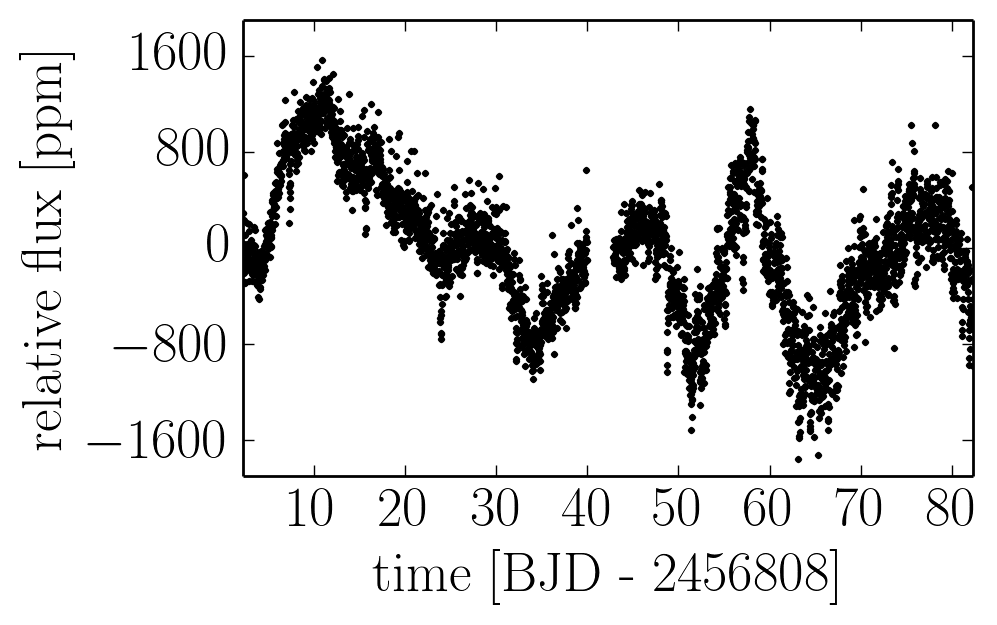

In [216]:
fig, ax = pl.subplots(1, 1, sharex=True, figsize=(5, 3))

ax.plot(lc.time, lc.flux * 1e3, ".k", ms=4)
ax.set_xlabel("time [BJD - 2456808]")
ax.set_ylabel("relative flux [ppm]")
ax.set_xlim(lc.time.min(), lc.time.max())
ax.yaxis.set_label_coords(-0.23, 0.5) 
ax.set_ylim(-1900, 1900)
ax.yaxis.set_major_locator(MaxNLocator(7))

fig.subplots_adjust(left=0.25, bottom=0.22, right=0.98, top=0.98, hspace=0.05)
fig.savefig("figures/raw-flux.pdf")

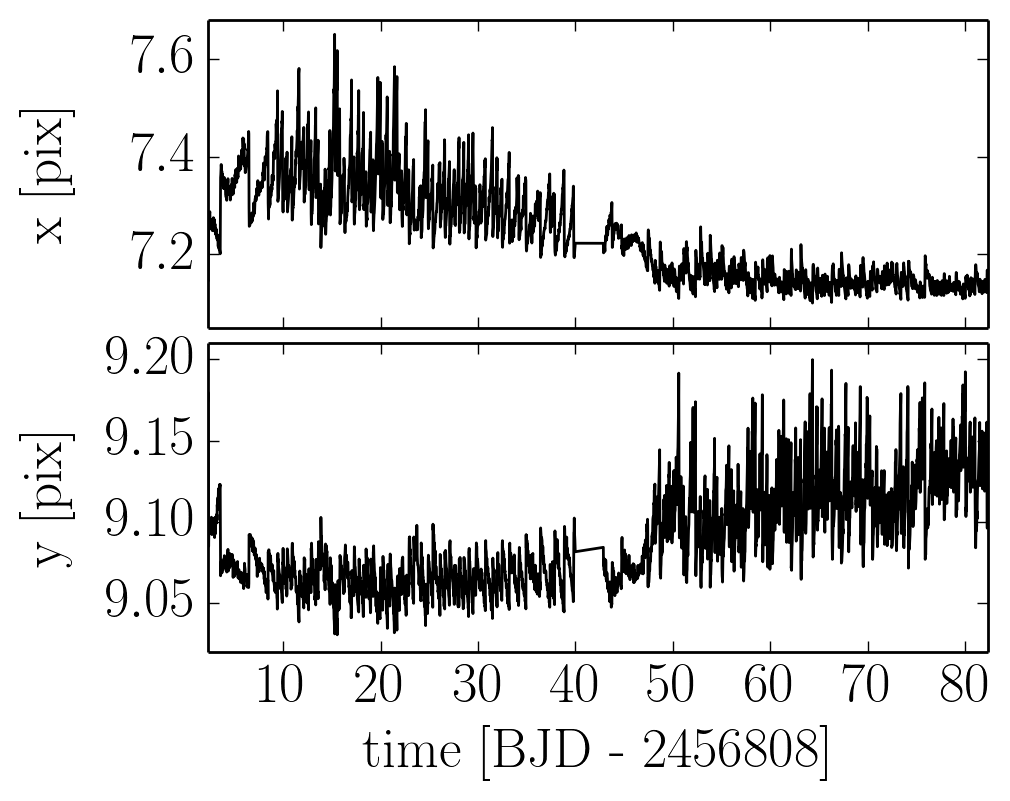

In [156]:
fig, axes = pl.subplots(2, 1, sharex=True, figsize=(5, 4))

axes[0].plot(lc.time, fp_model.coords[:, 0], "k")
axes[0].set_ylabel("x [pix]")
axes[0].yaxis.set_label_coords(-0.17, 0.5) 
axes[0].set_ylim(7.05, 7.68)
axes[0].yaxis.set_major_locator(MaxNLocator(5))

axes[1].plot(lc.time, fp_model.coords[:, 1], "k")
axes[1].set_ylabel("y [pix]")
axes[1].yaxis.set_label_coords(-0.17, 0.5) 
axes[1].set_ylim(9.02, 9.21)
axes[1].yaxis.set_major_locator(MaxNLocator(5))

axes[1].set_xlim(lc.time.min(), lc.time.max())
axes[1].set_xlabel("time [BJD - 2456808]")

fig.subplots_adjust(left=0.2, bottom=0.19, right=0.98, top=0.98, hspace=0.05)
fig.savefig("figures/centroid.pdf")

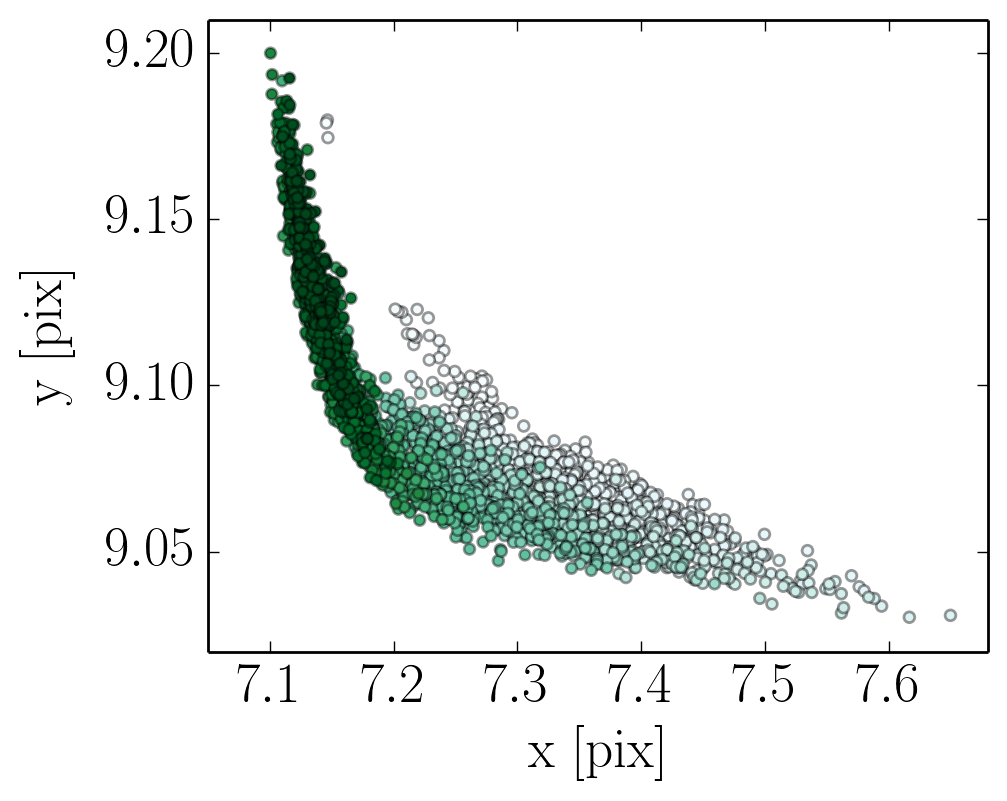

In [189]:
fig, ax = pl.subplots(1, 1, sharex=True, figsize=(5, 4))

c = (lc.time - lc.time.min()) / (lc.time.max() - lc.time.min())
ax.scatter(fp_model.coords[:, 0], fp_model.coords[:, 1], c=c,
           edgecolor=(0, 0, 0, 0.4), s=15, cmap="BuGn")
ax.set_xlim(7.05, 7.68)
ax.set_ylim(9.02, 9.21)
ax.yaxis.set_label_coords(-0.17, 0.5)
ax.set_xlabel("x [pix]")
ax.set_ylabel("y [pix]")

fig.subplots_adjust(left=0.2, bottom=0.19, right=0.98, top=0.98, hspace=0.05)
fig.savefig("figures/centroid-2.pdf")

We'll use the basis to de-trend this light curve:

In [204]:
mu = lc.predict()

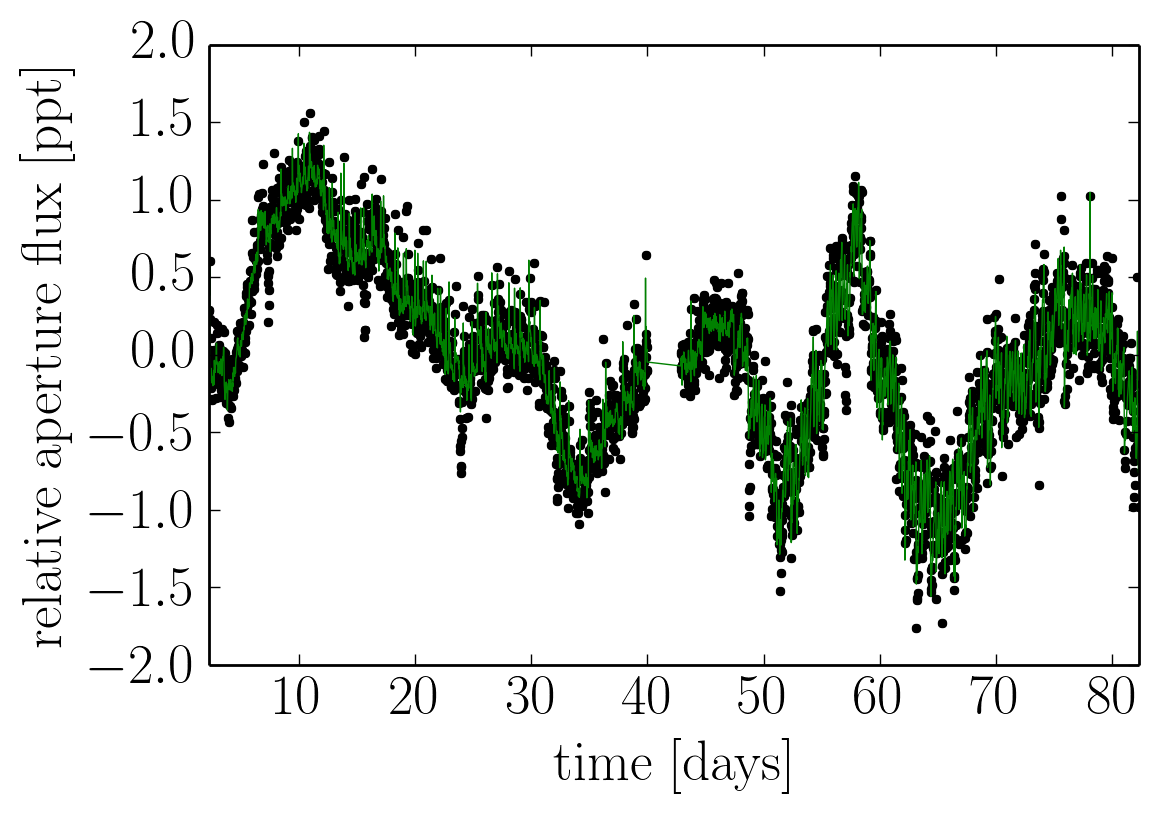

In [205]:
pl.plot(lc.time, lc.flux, ".k")
pl.plot(lc.time, mu, "g", lw=0.5)
pl.xlabel("time [days]")
pl.ylabel("relative aperture flux [ppt]")
pl.xlim(lc.time.min(), lc.time.max());

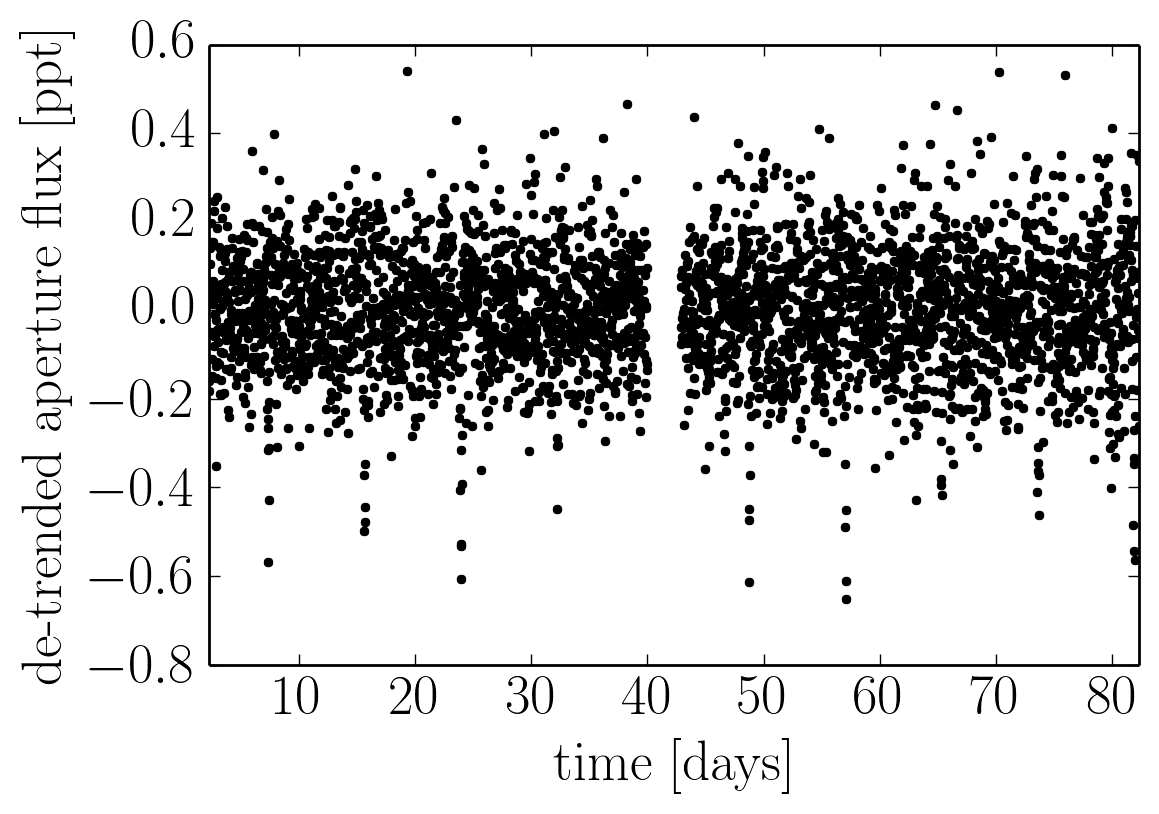

In [206]:
pl.plot(lc.time, lc.flux - mu, ".k")
pl.xlabel("time [days]")
pl.ylabel("de-trended aperture flux [ppt]")
pl.xlim(lc.time.min(), lc.time.max());

**Note**: this does overfit and the transits are distorted!!

## Linear search

In [207]:
pipe = ketu.k2.Data(basepath="./demo/cache")
pipe = ketu.k2.Likelihood(pipe)
pipe = ketu.OneDSearch(pipe)

In [208]:
query = dict(query,
    time_spacing=0.02,
    durations=[0.05, 0.1, 0.2],
)

In [209]:
result = pipe.query(**query)

Using cached value in OneDSearch


Here we'll plot the best-fit depth as a function of time. Each color represents a different duration.

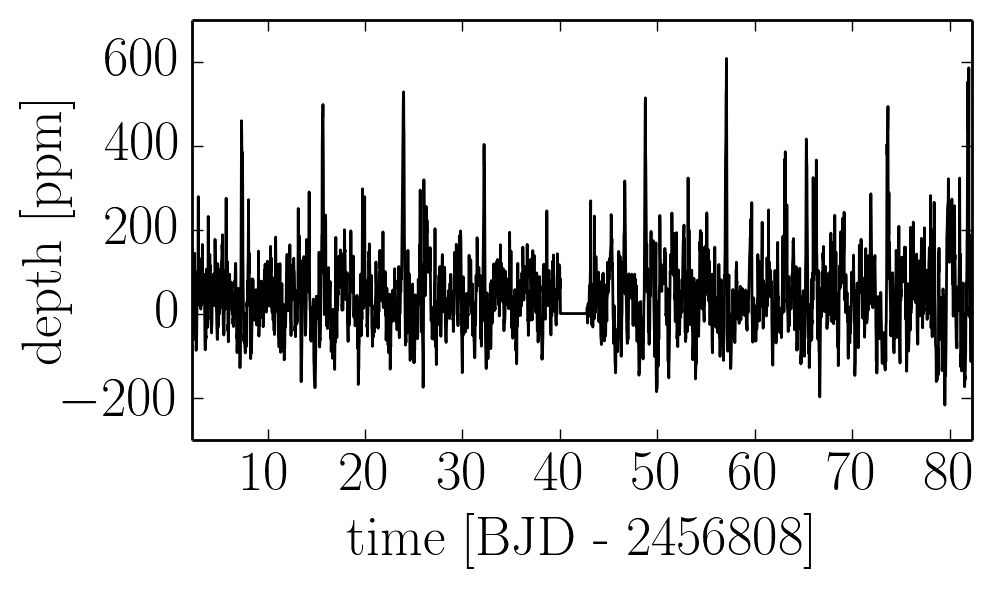

In [243]:
fig, ax = pl.subplots(1, 1, sharex=True, figsize=(5, 3))

time_grid = np.arange(result.min_time_1d, result.max_time_1d, result.time_spacing)

ax.plot(time_grid, 1e3 * np.max(result.depth_1d, axis=1), "k")
ax.set_xlabel("time [BJD - 2456808]")
ax.set_ylabel("depth [ppm]")
ax.set_xlim(lc.time.min(), lc.time.max())
ax.yaxis.set_label_coords(-0.15, 0.5)

fig.subplots_adjust(left=0.19, bottom=0.24, right=0.97, top=0.94, hspace=0.05)
fig.savefig("figures/linear.pdf")

## Periodic search

In [218]:
pipe = ketu.k2.Data(basepath="./demo/cache")
pipe = ketu.k2.Likelihood(pipe)
pipe = ketu.OneDSearch(pipe)
pipe = ketu.IterativeTwoDSearch(pipe)

In [221]:
query = dict(query,
    min_period=0.5,
    max_period=70.0,
    npeaks=1,
)

In [222]:
result = pipe.query(**query)

Using cached value in IterativeTwoDSearch


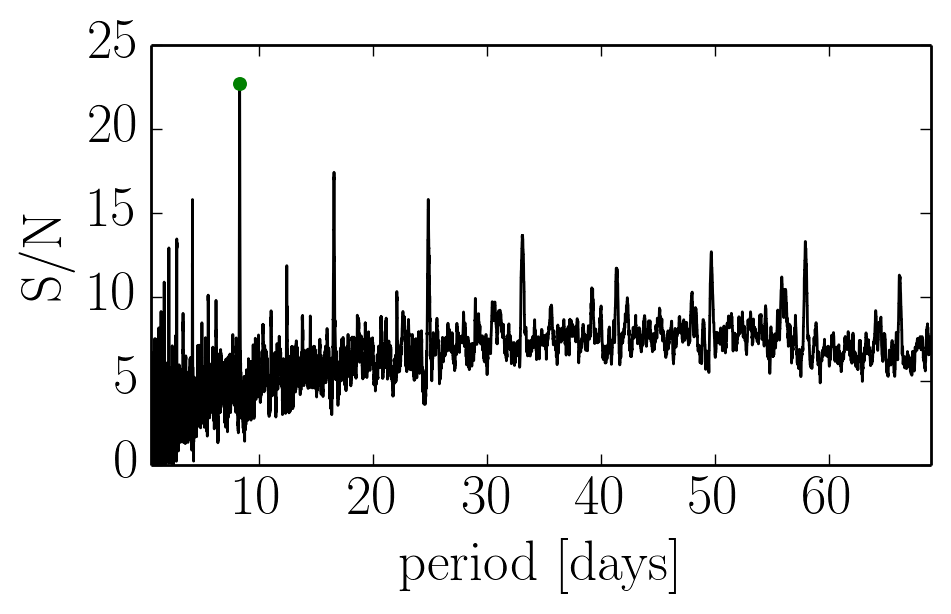

In [357]:
fig, ax = pl.subplots(1, 1, sharex=True, figsize=(5, 3))

ax.plot(result.period_2d, result.periodograms[0], "k")
ax.plot(peak["period"], peak["depth"] * np.sqrt(peak["depth_ivar"]), "og", mec="none", ms=5)

ax.set_xlim(query["min_period"], 69)
ax.set_xlabel("period [days]")
ax.set_ylabel("S/N")

fig.subplots_adjust(left=0.19, bottom=0.24, right=0.97, top=0.94, hspace=0.05)
fig.savefig("figures/periodic.pdf")

## Prediction

In [86]:
model = np.zeros_like(lc.time)
for peak in result.peaks:
    p, t0, dur, dep = peak["period"], peak["t0"], peak["duration"], peak["depth"]
    m = np.abs((lc.time - t0 + 0.5 * p) % p - 0.5 * p) < 0.5 * dur
    model[m] -= dep

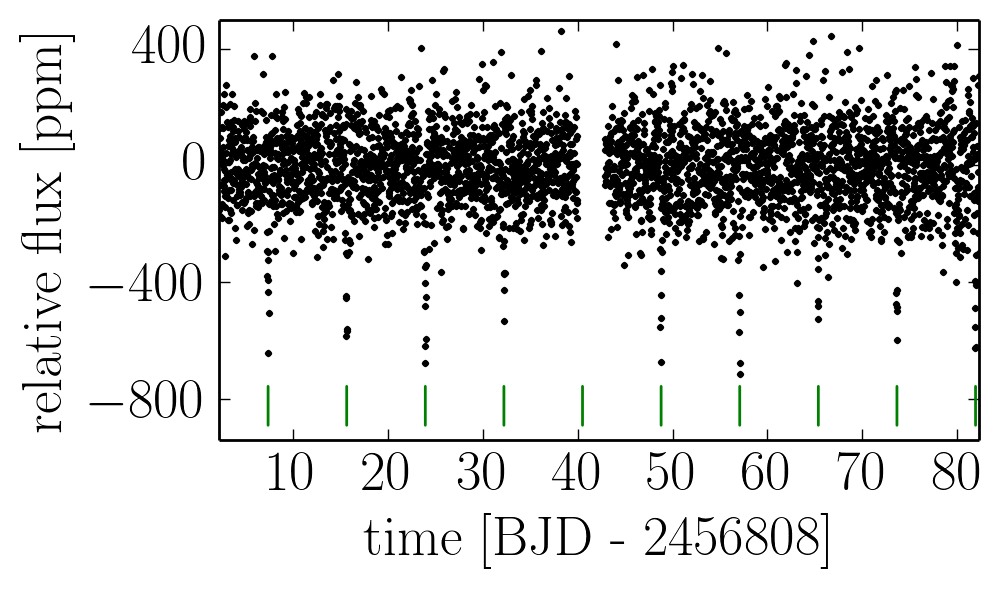

In [266]:
fig, ax = pl.subplots(1, 1, sharex=True, figsize=(5, 3))

mu = lc.predict(lc.flux - model)
ax.plot(lc.time, (lc.flux - mu) * 1e3, ".k", ms=4)
args = dict(xycoords="data", xytext=(0, -20), textcoords="offset points",
            ha="center", va="bottom", fontsize=12,
            arrowprops=dict(arrowstyle="-", shrinkA=0.0, shrinkB=6))

for peak, c in zip(result.peaks, "grb"):
    t = peak["t0"]
    args["arrowprops"]["edgecolor"] = c
    while t < lc.time.max():
        ax.annotate("", xy=(t, (-peak["depth"] - 0.35)*1e3), **args)
        t += peak["period"]

ax.set_ylabel("relative flux [ppm]")
ax.set_xlabel("time [BJD - 2456808]")

ax.set_xlim(lc.time.min(), lc.time.max())
ax.set_ylim(-940, 500)
ax.yaxis.set_major_locator(MaxNLocator(5))

fig.subplots_adjust(left=0.21, bottom=0.24, right=0.97, top=0.94, hspace=0.05)
fig.savefig("figures/de-trended.pdf")

In [286]:
with h5py.File("demo/chain.h5", "r") as f:
    samples = f["chain"][...]
    lnprob = f["lnprob"][...]

In [344]:
s, w = lnprob.shape
t = np.linspace(-0.9, 0.9, 1000)
y, mu = [], []
ps, t0s = [], []
for i in range(300):
    samp = samples[np.random.randint(s), np.random.randint(w)]
    sesn, secs = samp[8:]
    e = sesn**2 + secs**2
    pomega = np.arctan2(sesn, secs)
    p = np.exp(samp[5])
    t0 = samp[6]
    ps.append(p)
    t0s.append(t0)

    system = transit.System(transit.Central(radius=np.exp(samp[0]), mass=np.exp(samp[1]),
                                            q1=samp[2], q2=samp[3]))
    system.add_body(transit.Body(r=np.exp(samp[4]), period=p, t0=t0, b=samp[7],
                                 e=e, pomega=pomega))

    pred = (system.light_curve(lc.time, texp=lc.texp) - 1) * 1e3
    mu.append(lc.predict(lc.flux - pred))
    y.append((system.light_curve(t + t0, texp=lc.texp) - 1) * 1e6)
y = np.array(y)

In [348]:
p = np.median(ps)
t0 = np.median(t0s)
mean = np.median(y, axis=0)

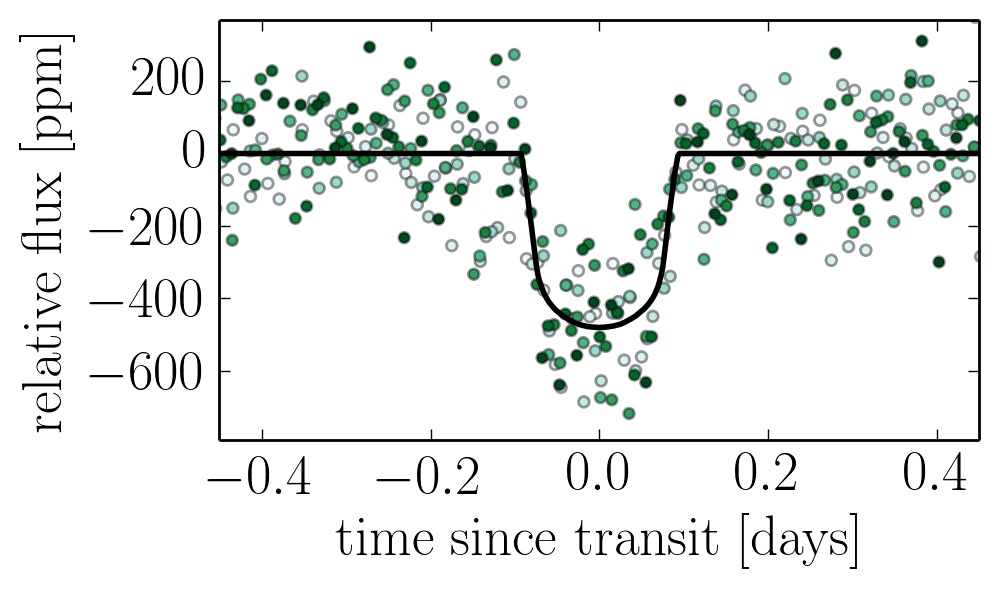

In [354]:
fig, ax = pl.subplots(1, 1, sharex=True, figsize=(5, 3))

c = (lc.time - lc.time.min()) / (lc.time.max() - lc.time.min())
ax.scatter((lc.time - t0 + 0.5*p) % p - 0.5*p, (lc.flux - np.mean(mu, axis=0)) * 1e3,
           c=c, edgecolor=(0, 0, 0, 0.4), s=15, cmap="BuGn")
ax.plot(t, mean, "k", lw=2)

ax.set_xlim(-0.45, 0.45)
ax.set_ylim(-790, 370)

ax.set_ylabel("relative flux [ppm]")
ax.set_xlabel("time since transit [days]")

fig.subplots_adjust(left=0.21, bottom=0.24, right=0.97, top=0.94, hspace=0.05)
fig.savefig("figures/folded.pdf")

In [318]:
e

0.43697901535144829